#### Notes on current version:
**Done**:

- $\checkmark$ Cayley parameterization](https://planetmath.org/cayleysparameterizationoforthogonalmatrices) of $SU_d$ (since this is really all we need)...*will it be more stable than Lie's parameterization?* Note: it is a homeomorphism so this is great for UAP!

**To do:**
  
- Implement Regression

- Implement Feature Map

# NEU (Reconfigurations Map and Related Functions)

### Basic Algorithm (NEU-OLS)

1. Perform Basic Algorithm (in this case OLS)
2. Map predictions to their graph; ie $x\mapsto (x,\hat{f}_{OLS}(x))$ where $\hat{f}_{OLS}$ is the least-squares regression function.

## Initializations:

In [1]:
# Data Structuring
import numpy as np
import pandas as pd


# Pre-Processing
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from scipy.special import expit

# Regression
from sklearn.linear_model import LinearRegression
from scipy import linalg as scila

# Tensorflow
import tensorflow as tf
import keras as K
import keras.backend as Kb
from keras.layers import *
from keras.models import Model
from keras.models import Sequential
from keras import layers
from keras import utils as np_utils
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras.constraints import NonNeg
from tensorflow.keras.optimizers import Adam

# Operating-System Related
import os
from pathlib import Path

# Visualization
from matplotlib.pyplot import figure

# z_Misc
import time
import math

Using TensorFlow backend.


## Check/Make Paths

In [2]:
Path('./outputs/models/').mkdir(parents=True, exist_ok=True)
Path('./outputs/models/Benchmarks/').mkdir(parents=True, exist_ok=True)
Path('./outputs/models/Benchmarks/Invertible_Networks/GLd_Net/').mkdir(parents=True, exist_ok=True)
Path('./outputs/models/Benchmarks/Invertible_Networks/Ed_Net/').mkdir(parents=True, exist_ok=True)
Path('./outputs/models/Benchmarks/Linear_Regression/').mkdir(parents=True, exist_ok=True)
Path('./outputs/models/NEU/').mkdir(parents=True, exist_ok=True)
Path('./outputs/models/NEU/Greedy_Initializations/').mkdir(parents=True, exist_ok=True)
Path('./outputs/models/NEU/Greedy_Initializations/Base_Regressor/').mkdir(parents=True, exist_ok=True)
Path('./outputs/tables/').mkdir(parents=True, exist_ok=True)
Path('./outputs/results/').mkdir(parents=True, exist_ok=True)
Path('./inputs/data/').mkdir(parents=True, exist_ok=True)

## Initialize Internal Variables/(Hyper)parameter(s)

In [3]:
#---------------------------------#
# General Formatting Parameter(s) #
#---------------------------------#
d = 1 # Dimension of X
D = 1 # Dimension of Y

#------------------------------------#
# Training/Optimization Parameter(s) #
#------------------------------------#
# Robustness Parameter
robustness_parameter = .1
# Training meta-parameters
Pre_Epochs = 50
Full_Epochs = 600

#---------------------------#
# Architecture Parameter(s) #
#---------------------------#
# Depth & Height of first Reconfiguration
Initial_Depth = 2
Initial_Height = 50
# Reconfiguration Parameters
N_Reconfigurations = 20
# Depth & Height Per Reconfiguration
Depth_per_reconfig = 20
Height_per_reconfig = 5

#-------------------#
# Data Parameter(s) #
#-------------------#
# Number of Datapoints
N_data = 10**3
Train_step_proportion = .5
# Noise Parameters
noise_level = .5
Distortion = .5
# Unknown Function:
def unknown_f(x):
    return .1*x + .1*(x**4) + x*np.exp(-np.abs(x)) + np.sin(4*x + 3*x**2) + np.cos(7*(x**2))+ (x % .5)

### Run External/Auxiliary Notebooks

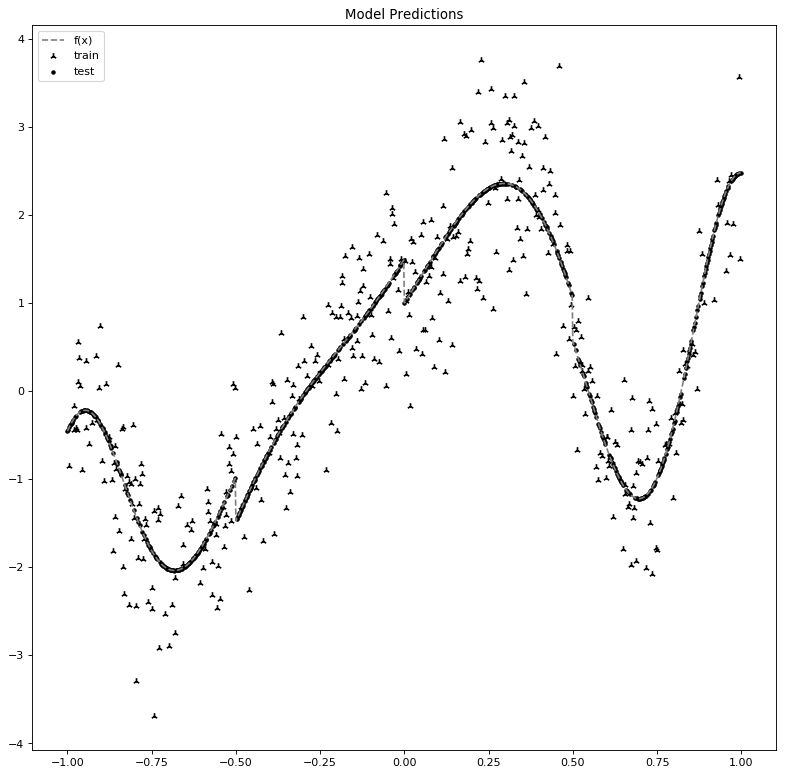

In [4]:
#------------------------#
# Run External Notebooks #
#------------------------#
# Generate Data
%run Data_Generator.ipynb
# Import Custom Layer(s)
%run Special_Layers_Homeomorphic.ipynb
# Import Utility for NEU
%run NEU_Util.ipynb
# Import Benchmarks
%run Benchmarks_Util.ipynb

#### Prepare data for NEU

## 1) Get Basic Regression Models
 1. Get Base regression model (benchmark),
 2. Get Base regression model for NEU.

## Get basic regression model - Benchmark

In [5]:
if os.path.exists('./outputs/models/Benchmarks/Linear_Regression/saved_model.pb'):
    #------------------#
    # Load Readout Map #
    #------------------#
    print('Benchmark model - already exists: Loading...')
    regression_Benchmark = tf.keras.models.load_model("./outputs/models/Benchmarks/Linear_Regression/")
    print('Benchmark model - already exists: Loaded.')
else:
    print('Pre-trained benchmark model does not exist: Training.')
    regression_Benchmark = def_model_Regression(data_x,
                                                data_y,
                                                Pre_Epochs_in=Full_Epochs,
                                                height=(N_Reconfigurations*Height_per_reconfig),
                                                depth=Initial_Depth,
                                                learning_rate=0.01)
    
    #-----------------#
    # Save Full-Model #
    #-----------------#
    print('Benchmark-Model: Saving')
    regression_Benchmark.save("./outputs/models/Benchmarks/Linear_Regression/")
    print('Benchmark-Model: Saved')
    
# Generate Predictions #
#----------------------#
predictions_OLS_Benchmark =  regression_Benchmark.predict(data_x)
predictions_OLS_Benchmark = predictions_OLS_Benchmark.reshape(-1,)
predictions_OLS_Benchmark_test =  regression_Benchmark.predict(data_x_test)
predictions_OLS_Benchmark_test = predictions_OLS_Benchmark_test.reshape(-1,)

Benchmark model - already exists: Loading...
Benchmark model - already exists: Loaded.


## Get base regression model for NEU

In [6]:
if os.path.exists('./outputs/models/Benchmarks/Greedy_Initializations/Base_Regressor/saved_model.pb'):
    #------------------#
    # Load Readout Map #
    #------------------#
    print('Base Regressor model - already exists: Loading...')
    regression_basic = tf.keras.models.load_model('./outputs/models/Benchmarks/Greedy_Initializations/Base_Regressor/', custom_objects={'Robust_MSE': Robust_MSE})
    print('Base Regressor model - already exists: Loaded.')
else:
    print('Pre-trained benchmark model does not exist: Training.')
    regression_basic = get_base_model_Regression(data_x, 
                                             data_NEU, 
                                             Pre_Epochs_in=Full_Epochs, 
                                             height=Initial_Height, 
                                             depth=Initial_Depth,
                                             learning_rate=0.01)
    
    
    #-----------------#
    # Save Full-Model #
    #-----------------#
    print('Base Regressor-Model: Saving')
    regression_basic.save("./outputs/models/Benchmarks/Greedy_Initializations/Base_Regressor/")
    print('Base Regressor-Model: Saved')
    
# Generate Predictions #
#----------------------#
predictions_OLS = regression_basic.predict(data_x)
predictions_OLS = predictions_OLS.reshape(-1,)
predictions_OLS_test = regression_basic.predict(data_x_test)

Base Regressor model - already exists: Loading...
Base Regressor model - already exists: Loaded.


### Generate Plots - Visualization

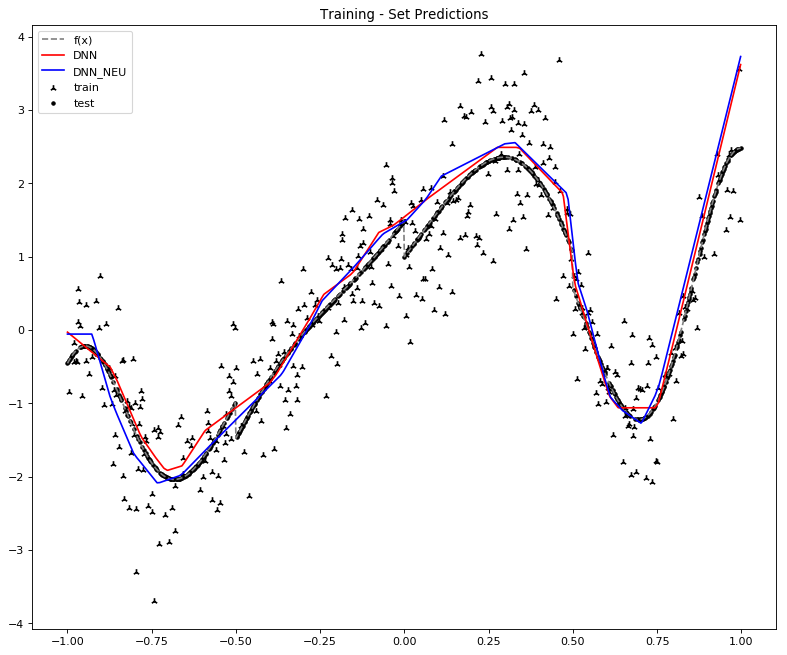

In [7]:
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')

# Generate Plots #
#----------------#

# Plot Signal
plt.plot(np.array(data_x_full).reshape(-1,),true_y,color='gray',label='f(x)',linestyle='--')
# Plot Data
plt.scatter(np.array(data_x).reshape(-1,),data_y,color='black',label='train', marker = '2')
plt.scatter(np.array(data_x_test).reshape(-1,),data_y_test,color='black',label='test', marker = '.')


# Plot Benchmark(s)
plt.plot(np.array(data_x_test).reshape(-1,),(predictions_OLS_Benchmark_test.reshape(-1,)), color = 'red', label='DNN')
# Plot NEU Regressors
plt.plot(np.array(data_x_test).reshape(-1,),predictions_OLS_test[:,1], color = 'blue',label='DNN_NEU')

# Format Plot #
#-------------#
plt.legend(loc="upper left")
plt.title("Training - Set Predictions")
plt.show()

## 3) Readout
 1. Get Base Model,
 2. Greedy Layer-Wise Initialization,
 3. Robust SGD on entire structure.
 
We train NEU-OLS, by unfreezing the greedily initialized layers, as per [this paper](https://papers.nips.cc/paper/3048-greedy-layer-wise-training-of-deep-networks.pdf), and using "robust"-SGD on the whole structure.

In [ ]:
#----------------------------------#
# Greedy Layer-Wise Initialization #
#----------------------------------#
if os.path.exists("./outputs/models/NEU/Greedy_Initializations/saved_model.pb"):
    #------------------#
    # Load Readout Map #
    #------------------#
    print('Pre-trained readout-map already exists: Loading.')
    NEU_OLS_Greedy_init = tf.keras.models.load_model("./outputs/models/NEU/Greedy_Initializations/")
    print('Saved pre-trained readout-map: Loaded.')
    #-----------------#
    # Load Full-Model #
    #-----------------#
    print('Full-model already exists: Loading.')
    NEU_OLS = tf.keras.models.load_model("./outputs/models/NEU/", custom_objects={'Robust_MSE': Robust_MSE})
    print('Full-Model: Loaded')
else:
    
    #------------------------------------------------------------------------------------------------------#
    #------------------------------------------------------------------------------------------------------#
    #------------------------------------------------------------------------------------------------------#
    #                                          Pre-Trained Model                                           #
    #------------------------------------------------------------------------------------------------------#
    #------------------------------------------------------------------------------------------------------#
    #------------------------------------------------------------------------------------------------------#
    
    print('Pre-trained model does not exist: Training.')
    # Greedy Initialization
    model = regression_basic
    NEU_OLS_Greedy_init = model
    for i in range(N_Reconfigurations):
        # Update Model
        NEU_OLS_Greedy_init_temp = add_reconfiguration_unit_greedily(NEU_OLS_Greedy_init,
                                                                     data_x,
                                                                     data_NEU,
                                                                     Pre_Epochs,
                                                                     Depth_per_reconfig,
                                                                     Height_per_reconfig)

        # Check for Blowup
        if math.isnan(np.mean(NEU_OLS_Greedy_init.predict(data_x))):
            NEU_OLS_Greedy_init = NEU_OLS_Greedy_init
            break
        else: #Update Model if not explosion
            NEU_OLS_Greedy_init = NEU_OLS_Greedy_init_temp

        #-------------#
        # Update User #
        #-------------#
        print(np.mean(np.abs((NEU_OLS_Greedy_init.predict(data_x) - data_NEU)**2)))
        # Update User on Status of Initialization
        print(((i+1)/N_Reconfigurations))
        
    # Update User of Pre-Training Completion
    print('Complete: Pre-Training Readout Map on Input x Output Space!')
    
    #------------------------------------#
    # Save Greedily Initialized Layer(s) #
    #------------------------------------#
    print('Saving Pre-Trained Readout on Input x Output Space!')
    NEU_OLS_Greedy_init.save("./outputs/models/NEU/Greedy_Initializations/")
    
    
    #------------------------------------------------------------------------------------------------------#
    #------------------------------------------------------------------------------------------------------#
    #------------------------------------------------------------------------------------------------------#
    #                                             Full Model                                               #
    #------------------------------------------------------------------------------------------------------#
    #------------------------------------------------------------------------------------------------------#
    #------------------------------------------------------------------------------------------------------#
    
    print('(Full-)Model does not exist: Training.')
    NEU_OLS = build_reconfiguration(model_greedy_initialized=NEU_OLS_Greedy_init, 
                                    trainx = data_x, 
                                    trainy = data_y, 
                                    Full_Epochs_in = Full_Epochs, 
                                    height = Height_per_reconfig)
    #-----------------#
    # Save Full-Model #
    #-----------------#
    print('Full-Model: Saving')
    NEU_OLS.save("./outputs/models/NEU/")
    print('Full-Model: Saved')
    

# Make Predictions #
#------------------#
# Predictions Train
NEU_OLS_greedy_initializations = NEU_OLS_Greedy_init.predict(data_x)
NEU_OLS_prediction = NEU_OLS.predict(data_x)
NEU_OLS_prediction = NEU_OLS_prediction.reshape(-1,)
# Predictions Test
NEU_OLS_greedy_initializations_test = NEU_OLS_Greedy_init.predict(data_x_test)
NEU_OLS_prediction_test = NEU_OLS.predict(data_x_test)
NEU_OLS_prediction_test = NEU_OLS_prediction_test.reshape(-1,)

    
# Update User #
#-------------#
print('NEU: Ready!')

Pre-trained model does not exist: Training.
1.4300698419147735
0.05
0.4251489529392745
0.1
5.097026280716719
0.15
4.90267847940614
0.2
4.198599730974189
0.25
0.9812166416563598
0.3
1.6880041204132912
0.35
4.2580231267841295
0.4
4.3091047614698725
0.45
4.712581114189656
0.5
4.143535044405908
0.55
0.7659857889972909
0.6


### Generate Plots - Visualization

In [ ]:
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')

# Generate Plots #
#----------------#

# Plot Signal
plt.plot(np.array(data_x_full).reshape(-1,),true_y,color='gray',label='f(x)',linestyle='--')
# Plot Data
plt.scatter(np.array(data_x).reshape(-1,),data_y,color='black',label='train', marker = '2')
plt.scatter(np.array(data_x_test).reshape(-1,),data_y_test,color='black',label='test', marker = '.')

# Plot Benchmark(s)
plt.plot(np.array(data_x_test).reshape(-1,),(predictions_OLS_Benchmark_test), color = 'red', label='DNN')


# Plot NEU Regressors
plt.plot(np.array(data_x_test).reshape(-1,),predictions_OLS_test[:,1], color = 'blue',label='DNN_NEU')
plt.plot(np.array(data_x_test).reshape(-1,),(NEU_OLS_greedy_initializations_test[:,-1]), color = 'lightgreen',label='NEU-Reg-Init')
plt.plot(np.array(data_x_test).reshape(-1,),(NEU_OLS_prediction_test), color = 'green',label='NEU-Reg')

# Format Plot #
#-------------#
plt.legend(loc="upper left")
plt.title("Model Predictions")
plt.show()

---
---
---

# Benchmark Models

In [ ]:
#------------------#
# Train GLd-Model  #
#------------------#
if os.path.exists("./outputs/models/Benchmarks/Invertible_Networks/GLd_Net/saved_model.pb"):
    print('GLd-Nets Trained model already exists: Loading.')
    Deep_GLd = tf.keras.models.load_model("./outputs/models/Benchmarks/Invertible_Networks/GLd_Net/")
    print('GLd-Nets trained model: Loaded.')
else:
    print('GLd-Nets Model does not exist: Training.')
    # Basic Model
    regression_basic_nonrobust = get_base_model_Regression_nonrobust(data_x, 
                                             data_NEU, 
                                             Pre_Epochs_in=200, 
                                             height=100, 
                                             depth=10,
                                             learning_rate=0.01)
    # NEU Version
    Deep_GLd = build_reconfiguration_GLd(model_greedy_initialized=regression_basic_nonrobust, 
                                    trainx = data_x, 
                                    trainy = data_y, 
                                    Full_Epochs_in = Full_Epochs, 
                                    depth= (Depth_per_reconfig*N_Reconfigurations))
    
    #--------------------#
    # Save GLd-Net-Model #
    #--------------------#
    print('GLd-Nets Model: Saving')
    Deep_GLd.save("./outputs/models/Benchmarks/Invertible_Networks/GLd_Net/")
    print('GLd-Nets Model: Saved')

    
# Predictions Train
Deep_GLd_prediction = Deep_GLd.predict(data_x)
Deep_GLd_prediction = Deep_GLd_prediction.reshape(-1,)
# Predictions Test
Deep_GLd_prediction_test = Deep_GLd.predict(data_x_test)
Deep_GLd_prediction_test = Deep_GLd_prediction_test.reshape(-1,)
    
# Update User #
#-------------#
print('Benchmark Model - GLd-Nets: Ready!')

In [ ]:
#-----------------#
# Train Ed-Model  #
#-----------------#
if os.path.exists("./outputs/models/Benchmarks/Invertible_Networks/Ed_Net/saved_model.pb"):
    print('Ed-Nets Trained model already exists: Loading.')
    Deep_Ed = tf.keras.models.load_model("./outputs/models/Benchmarks/Invertible_Networks/Ed_Net/")
    print('Ed-Nets trained model: Loaded.')
else:
    print('Ed-Nets Model does not exist: Training.')
    Deep_Ed=build_reconfiguration_Ed(model_greedy_initialized=regression_basic_nonrobust, 
                                    trainx = data_x, 
                                    trainy = data_y, 
                                    Full_Epochs_in = Full_Epochs, 
                                    depth= (Depth_per_reconfig*N_Reconfigurations))
    
    #--------------------#
    # Save GLd-Net-Model #
    #--------------------#
    print('Ed-Nets Model: Saving')
    Deep_Ed.save("./outputs/models/Benchmarks/Invertible_Networks/Ed_Net/")
    print('Ed-Nets Model: Saved')
    
    
# Predictions Train
Deep_Ed_prediction = Deep_Ed.predict(data_x)
Deep_Ed_prediction = Deep_Ed_prediction.reshape(-1,)
# Predictions Test
Deep_Ed_prediction_test = Deep_Ed.predict(data_x_test)
Deep_Ed_prediction_test = Deep_Ed_prediction_test.reshape(-1)
    
# Update User #
#-------------#
print('Benchmark Model - Ed-Nets: Ready!')

Run univariate regression benchmarks file:

In [ ]:
# Run Univariate Regression File #
#--------------------------------#
%run Univariate_Regression_Benchmark_Models.ipynb

## Model Evaluation: 
*Record Error(s)/Prediction Quality*

Train results.

In [ ]:
# Train Set #
#-----------#
Vanilla = get_results(predictions_OLS_Benchmark,data_y)
NEU = get_results(NEU_OLS_prediction,data_y)
NEU_Gld = get_results(Deep_GLd_prediction,data_y)
NEU_Ed = get_results(Deep_Ed_prediction,data_y)
SSplines = get_results(f_hat_smoothing_splines_train,data_y)
LOESS = get_results(LOESS_prediction_train,data_y)

# Write to DataFrame
Results = pd.DataFrame({'Vanilla': Vanilla,
                             'NEU': NEU,
                             'NEU_GLd': NEU_Gld,
                             'NEU_Ed':NEU_Ed,
                             'Smoothing_Splines':SSplines,
                             'LOESS':LOESS},index={'MAE','MinE','MaxE','MSE','rMSE'})
# Format
Results = pd.DataFrame.transpose(Results)

# Write Results to file #
#-----------------------#
Results.to_latex('./outputs/results/Performance.txt')
# Write to Txt
cur_path = os.path.expanduser('./outputs/results/Performance_text.txt')
with open(cur_path, "w") as f:
    f.write(str(Results))

Test results.

In [ ]:
# Test Set #
#----------#
Vanilla = get_results(predictions_OLS_Benchmark_test,data_y_test)
NEU = get_results(NEU_OLS_prediction_test,data_y_test)
NEU_Gld = get_results(Deep_GLd_prediction_test,data_y_test)
NEU_Ed = get_results(Deep_Ed_prediction_test,data_y_test)
SSplines = get_results(f_hat_smoothing_splines_test,data_y_test)
LOESS = get_results(LOESS_prediction_test,data_y_test)

# Write to DataFrame
Results_test = pd.DataFrame({'Vanilla': Vanilla,
                             'NEU': NEU,
                             'NEU_GLd': NEU_Gld,
                             'NEU_Ed':NEU_Ed,
                             'Smoothing_Splines':SSplines,
                             'LOESS':LOESS},index={'MAE','MinE','MaxE','MSE','rMSE'})
# Format
Results_test = pd.DataFrame.transpose(Results_test)

# Write Results to file #
#-----------------------#
Results_test.to_latex('./outputs/results/Performance_test.txt')
# Write to Txt
cur_path = os.path.expanduser('./outputs/results/Performance_test_text.txt')
with open(cur_path, "w") as f:
    f.write(str(Results_test))

# Visualize Predictions

In [ ]:
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')

# Generate Plots #
#----------------#

# Plot Signal
plt.plot(np.array(data_x_full).reshape(-1,),true_y,color='gray',label='f(x)',linestyle='--')
# Plot Data
plt.scatter(np.array(data_x).reshape(-1,),data_y,color='black',label='train', marker = '2')
plt.scatter(np.array(data_x_test).reshape(-1,),data_y_test,color='black',label='test', marker = '.')

# Plot Benchmark(s)
#------------------#
# Standard Benchmarks
plt.plot(np.array(data_x_test).reshape(-1,),(predictions_OLS_Benchmark_test), color = 'red', label='DNN')
# Plot Univariate Benchmark(s)
plt.plot(np.array(data_x_test).reshape(-1,),f_hat_smoothing_splines_test,color='pink',label='Splines')
plt.plot(np.array(data_x_test).reshape(-1,),LOESS_prediction_test,color='purple',label='LOESS')
# NEU Benchmarks: Alternatives to reconfigurations
plt.plot(np.array(data_x_test).reshape(-1,),Deep_GLd_prediction_test,color='lightblue',label='Deep-GLd')
plt.plot(np.array(data_x_test).reshape(-1,),Deep_Ed_prediction_test,color='orange',label='Deep-Ed')

# Plot NEU Regressors
plt.plot(np.array(data_x_test).reshape(-1,),predictions_OLS_test[:,1], color = 'blue',label='DNN_NEU')
plt.plot(np.array(data_x_test).reshape(-1,),(NEU_OLS_greedy_initializations_test[:,-1]), color = 'lightgreen',label='NEU-Reg-Init')
plt.plot(np.array(data_x_test).reshape(-1,),(NEU_OLS_prediction_test), color = 'green',label='NEU-Reg')

# Format Plot #
#-------------#
plt.legend(loc="upper left")
plt.title("Model Predictions")
plt.show()

 ---

# Report Results

In [ ]:
print('Train Results:')
Results.style.apply(lambda col: ['font-weight:bold' if x==col.min() else '' for x in col])

In [ ]:
print('Test Results:')
Results_test.style.apply(lambda col: ['font-weight:bold' if x==col.min() else '' for x in col])

#### The END

---